In [ ]:
!apt-get update && apt-get install -y libgl1-mesa-glx  # Fix OpenCV display issues
!pip install torch torchvision safetensors huggingface_hub numpy opencv-python matplotlib pillow


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:6 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,321 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,664 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,235 kB]
Get:13 http://archive.ubuntu.com

In [ ]:
!git clone https://github.com/Westlake-AGI-Lab/Distill-Any-Depth.git

Cloning into 'Distill-Any-Depth'...
remote: Enumerating objects: 1156, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 1156 (delta 34), reused 67 (delta 18), pack-reused 1060 (from 1)
Receiving objects: 100% (1156/1156), 32.83 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (225/225), done.


In [ ]:
%cd Distill-Any-Depth

/content/Distill-Any-Depth


In [ ]:
from huggingface_hub import hf_hub_download

# Download the large model checkpoint
checkpoint_path = hf_hub_download(repo_id="xingyang1/Distill-Any-Depth", filename="large/model.safetensors", repo_type="model")
print(f"Model downloaded at: {checkpoint_path}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Model downloaded at: /root/.cache/huggingface/hub/models--xingyang1--Distill-Any-Depth/snapshots/54b4f08b21ae1268f069f1e055fb2e596ec1054c/large/model.safetensors


In [ ]:
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Uploaded Image: {image_path}")

Saving IMG_0261.JPG to IMG_0261.JPG
Uploaded Image: IMG_0261.JPG


Using device: cuda


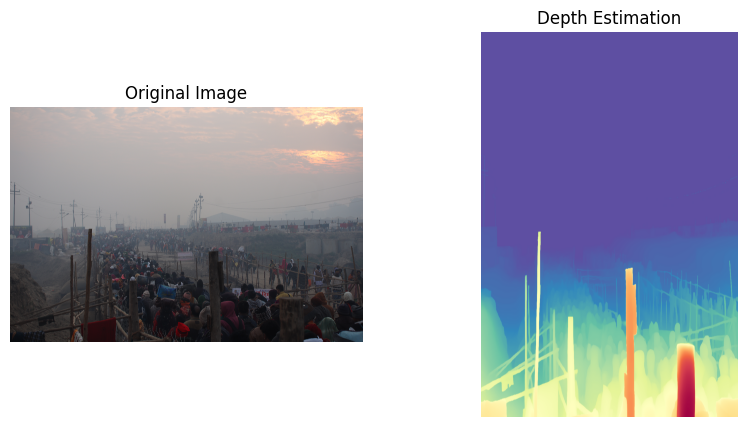

Depth map saved as depth_output.jpg


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from safetensors.torch import load_file
from distillanydepth.modeling.archs.dam.dam import DepthAnything
from distillanydepth.utils.image_util import chw2hwc, colorize_depth_maps
from distillanydepth.midas.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = DepthAnything().to(device)  # Initialize model WITHOUT checkpoint path

model_weights = load_file(checkpoint_path)  # Load safetensors weights
model.load_state_dict(model_weights)  # Apply weights to the model
model.eval()  # Set model to evaluation mode

# Preprocess Image
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)[..., ::-1] / 255  # Convert to numpy and normalize

    transform = Compose([
        Resize(756, 756, resize_target=False, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet()
    ])

    image_tensor = transform({'image': image_np})['image']
    image_tensor = torch.from_numpy(image_tensor).unsqueeze(0).to(device)
    return image, image_tensor

# Run Depth Estimation
def estimate_depth(image_path):
    image, image_tensor = preprocess_image(image_path)

    with torch.no_grad():
        pred_disp, _ = model(image_tensor)

    pred_disp_np = pred_disp.cpu().detach().numpy()[0, 0, :, :]
    pred_disp = (pred_disp_np - pred_disp_np.min()) / (pred_disp_np.max() - pred_disp_np.min())
    depth_colored = colorize_depth_maps(pred_disp[None, ..., None], 0, 1, cmap="Spectral_r").squeeze()
    depth_colored = (depth_colored * 255).astype(np.uint8)
    depth_colored_hwc = chw2hwc(depth_colored)

    h, w = image.size
    depth_colored_hwc = cv2.resize(depth_colored_hwc, (w, h), cv2.INTER_LINEAR)
    depth_image = Image.fromarray(depth_colored_hwc)

    return image, depth_image

# Run inference
original, depth_map = estimate_depth(image_path)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(depth_map)
plt.title("Depth Estimation")
plt.axis("off")

plt.show()

# Save output
depth_map.save("depth_output.jpg")
print("Depth map saved as depth_output.jpg")

Using device: cuda


Saving IMG_0274.JPG to IMG_0274.JPG
Processing image: IMG_0274.JPG


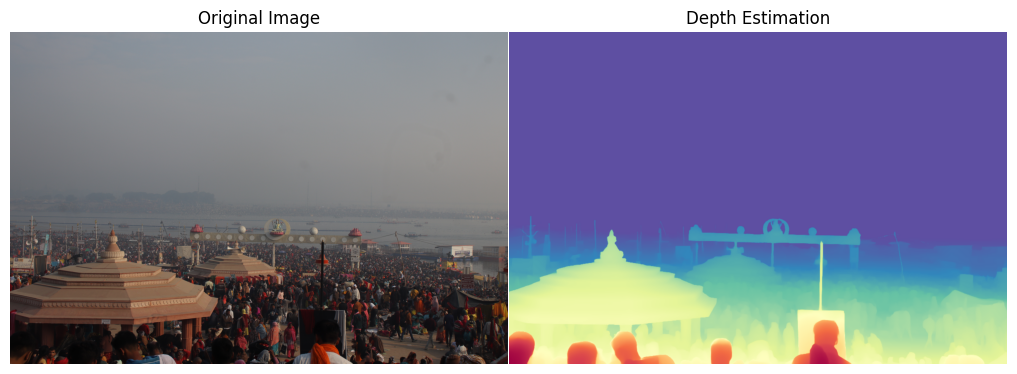

Depth map saved: depth_IMG_0274.JPG


In [ ]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from safetensors.torch import load_file
from huggingface_hub import hf_hub_download
from distillanydepth.modeling.archs.dam.dam import DepthAnything
from distillanydepth.utils.image_util import chw2hwc, colorize_depth_maps
from distillanydepth.midas.transforms import Resize, NormalizeImage, PrepareForNet
from torchvision.transforms import Compose
from google.colab import files

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Download model checkpoint
checkpoint_path = hf_hub_download(
    repo_id="xingyang1/Distill-Any-Depth",
    filename="large/model.safetensors",
    repo_type="model"
)

# Load model
model = DepthAnything().to(device)
model_weights = load_file(checkpoint_path)
model.load_state_dict(model_weights)
model.eval()

# Image preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)[..., ::-1] / 255  # Convert to numpy and normalize

    transform = Compose([
        Resize(756, 756, resize_target=False, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet()
    ])

    image_tensor = transform({'image': image_np})['image']
    image_tensor = torch.from_numpy(image_tensor).unsqueeze(0).to(device)

    return image, image_tensor

# Depth estimation function
def estimate_depth(image_path):
    image, image_tensor = preprocess_image(image_path)
    original_size = image.size  # Save original size

    with torch.no_grad():
        pred_disp, _ = model(image_tensor)

    pred_disp_np = pred_disp.cpu().detach().numpy()[0, 0, :, :]
    pred_disp = (pred_disp_np - pred_disp_np.min()) / (pred_disp_np.max() - pred_disp_np.min())
    depth_colored = colorize_depth_maps(pred_disp[None, ..., None], 0, 1, cmap="Spectral_r").squeeze()
    depth_colored = (depth_colored * 255).astype(np.uint8)
    depth_colored_hwc = chw2hwc(depth_colored)

    # Resize depth map to match original image dimensions
    depth_colored_hwc = cv2.resize(depth_colored_hwc, original_size, cv2.INTER_LINEAR)
    depth_image = Image.fromarray(depth_colored_hwc)

    return image, depth_image

# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")


Saving IMG_0263.JPG to IMG_0263.JPG
Processing image: IMG_0263.JPG


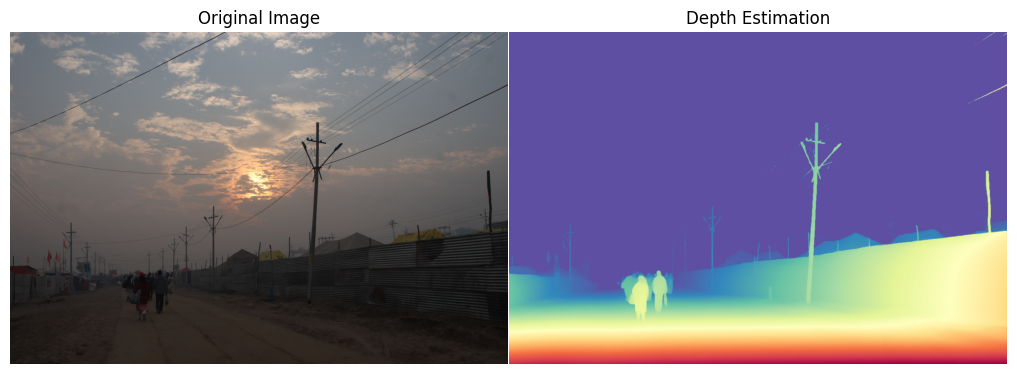

Depth map saved: depth_IMG_0263.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0225.JPG to IMG_0225.JPG
Processing image: IMG_0225.JPG


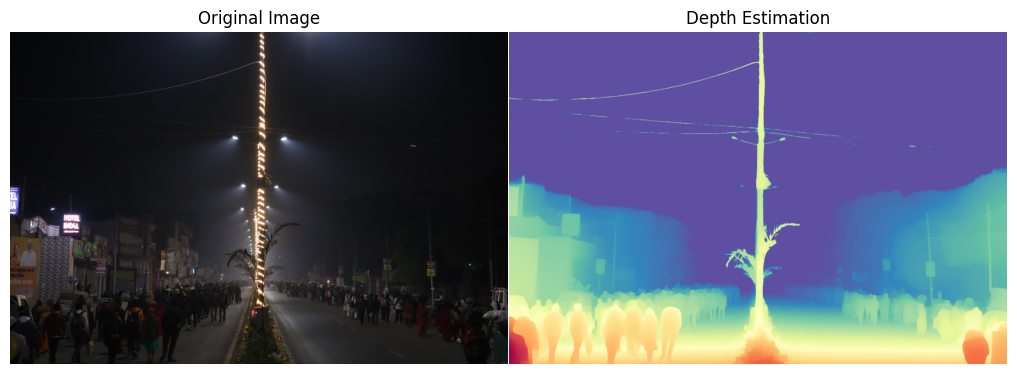

Depth map saved: depth_IMG_0225.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0283.JPG to IMG_0283.JPG
Processing image: IMG_0283.JPG


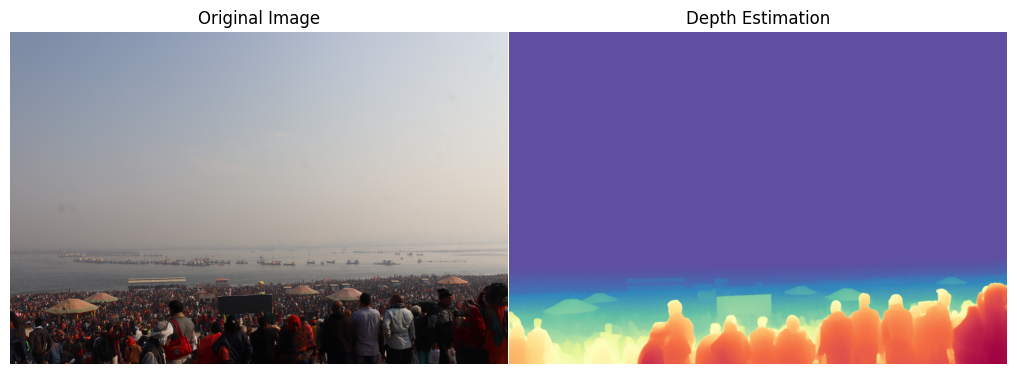

Depth map saved: depth_IMG_0283.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0340.JPG to IMG_0340.JPG
Processing image: IMG_0340.JPG


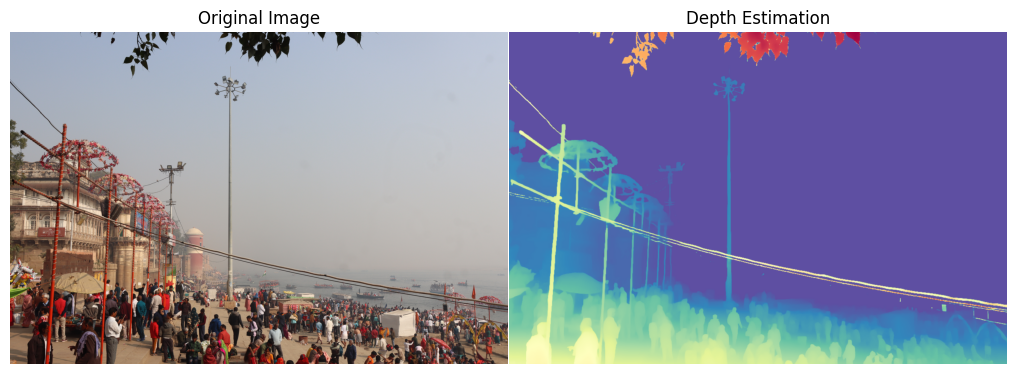

Depth map saved: depth_IMG_0340.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0339.JPG to IMG_0339.JPG
Processing image: IMG_0339.JPG


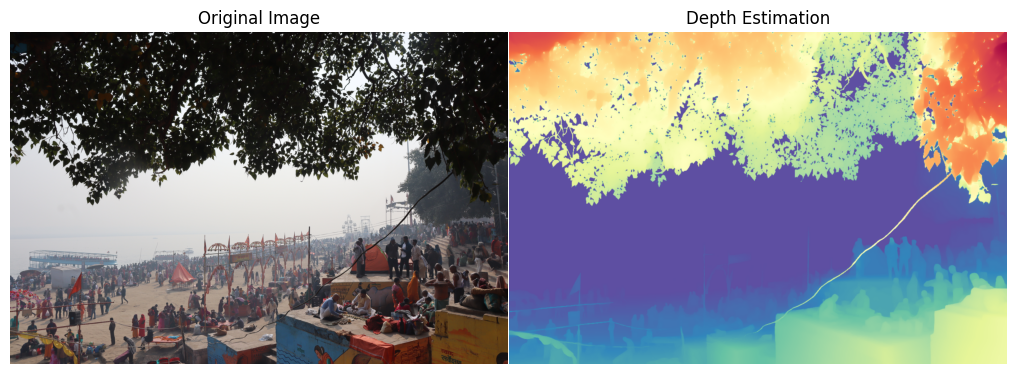

Depth map saved: depth_IMG_0339.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0691.JPG to IMG_0691.JPG
Processing image: IMG_0691.JPG


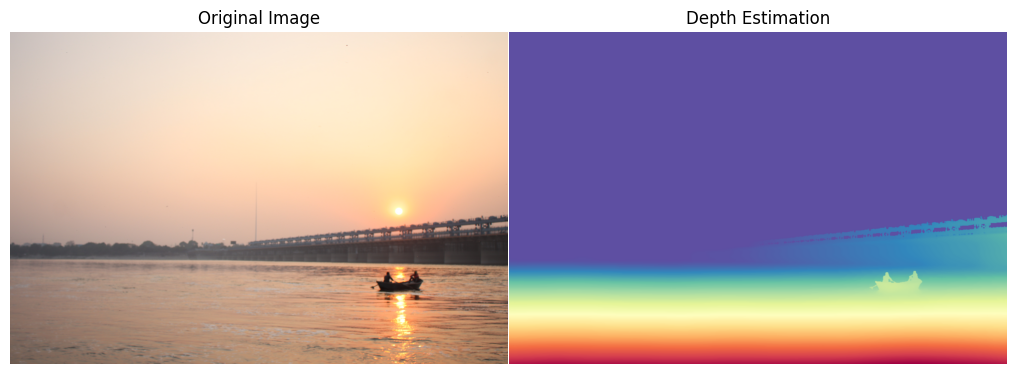

Depth map saved: depth_IMG_0691.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0260.JPG to IMG_0260.JPG
Processing image: IMG_0260.JPG


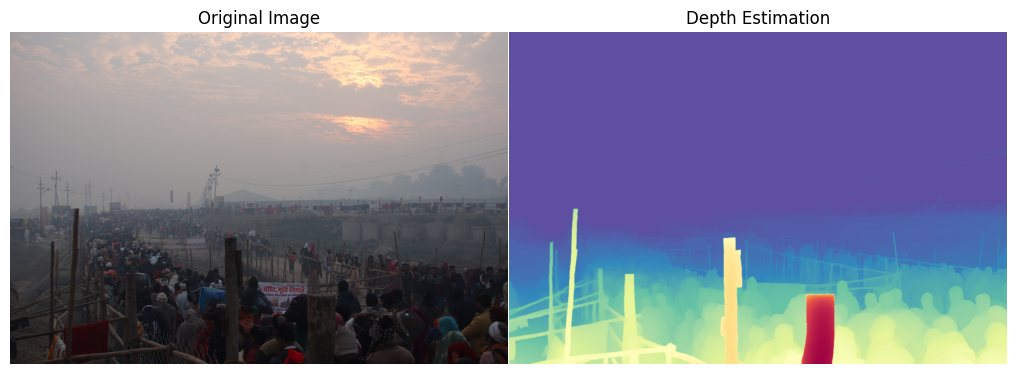

Depth map saved: depth_IMG_0260.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

Saving IMG_0257.JPG to IMG_0257.JPG
Processing image: IMG_0257.JPG


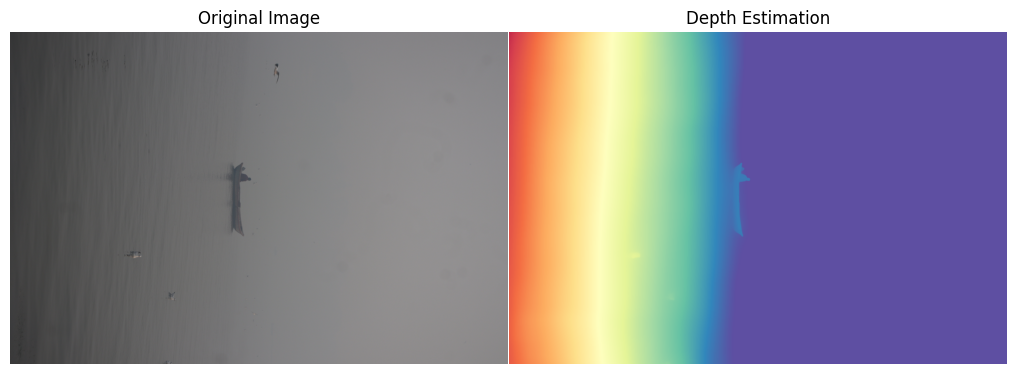

Depth map saved: depth_IMG_0257.JPG


In [ ]:
# Upload and process one image at a time
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the uploaded file name

print(f"Processing image: {image_path}")

# Run inference
original, depth_map = estimate_depth(image_path)

# Save output
output_path = f"depth_{image_path}"
depth_map.save(output_path)

# Display input and output side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)  # Adjust figure size for compact display
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(depth_map)
ax[1].set_title("Depth Estimation")
ax[1].axis("off")

plt.tight_layout(pad=0.1)  # Reduce extra space
plt.show()

print(f"Depth map saved: {output_path}")

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 46.4 MB/s eta 0:00:00


In [ ]:
# Image preprocessing function
def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)[..., ::-1] / 255  # Convert to numpy and normalize

    transform = Compose([
        Resize(756, 756, resize_target=False, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet()
    ])

    image_tensor = transform({'image': image_np})['image']
    image_tensor = torch.from_numpy(image_tensor).unsqueeze(0).to(device)

    return image, image_tensor

# Depth estimation function
def estimate_depth(image_path):
    image, image_tensor = preprocess_image(image_path)
    original_size = image.size

    with torch.no_grad():
        pred_disp, _ = model(image_tensor)

    pred_disp_np = pred_disp.cpu().detach().numpy()[0, 0, :, :]
    pred_disp = (pred_disp_np - pred_disp_np.min()) / (pred_disp_np.max() - pred_disp_np.min())

    # Create a heatmap from the depth map
    heatmap = cv2.applyColorMap((pred_disp * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, original_size, cv2.INTER_LINEAR)

    return image, heatmap


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model (pre-trained on COCO dataset)
yolo_model = YOLO("yolo11l.pt")  # Using the lightweight version

# Object detection function
def detect_objects(image_path):
    results = yolo_model(image_path)  # Run detection
    return results[0]  # Return first result



100%|██████████| 49.0M/49.0M [00:00<00:00, 132MB/s]


Saving IMG_0226.JPG to IMG_0226.JPG

image 1/1 /content/Distill-Any-Depth/IMG_0226.JPG: 448x640 12 persons, 1 handbag, 1 suitcase, 1 kite, 57.9ms
Speed: 7.3ms preprocess, 57.9ms inference, 353.1ms postprocess per image at shape (1, 3, 448, 640)


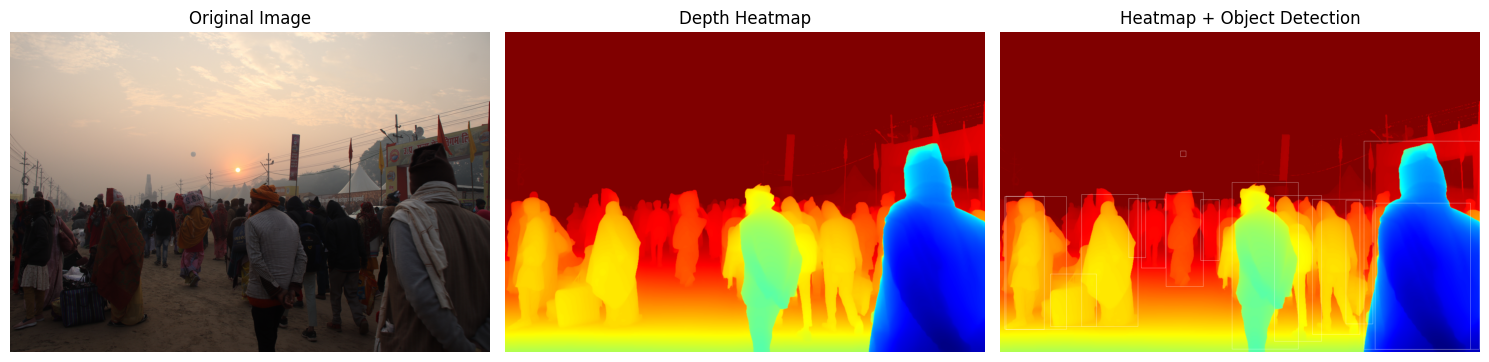

In [ ]:
import cv2

# Upload and process one image
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run depth estimation
original, heatmap = estimate_depth(image_path)

# Run object detection
detection_result = detect_objects(image_path)

# Draw bounding boxes on heatmap
def draw_detections(heatmap, detection_result):
    annotated_heatmap = heatmap.copy()

    for box in detection_result.boxes.xyxy:  # Get bounding boxes
        x1, y1, x2, y2 = map(int, box)  # Convert to int
        cv2.rectangle(annotated_heatmap, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White box

    return annotated_heatmap

# Overlay object detection on heatmap
annotated_heatmap = draw_detections(heatmap, detection_result)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap)
ax[1].set_title("Depth Heatmap")
ax[1].axis("off")

ax[2].imshow(annotated_heatmap)
ax[2].set_title("Heatmap + Object Detection")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Saving IMG_0225.JPG to IMG_0225 (1).JPG

image 1/1 /content/Distill-Any-Depth/IMG_0225 (1).JPG: 448x640 17 persons, 1 backpack, 56.5ms
Speed: 3.4ms preprocess, 56.5ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


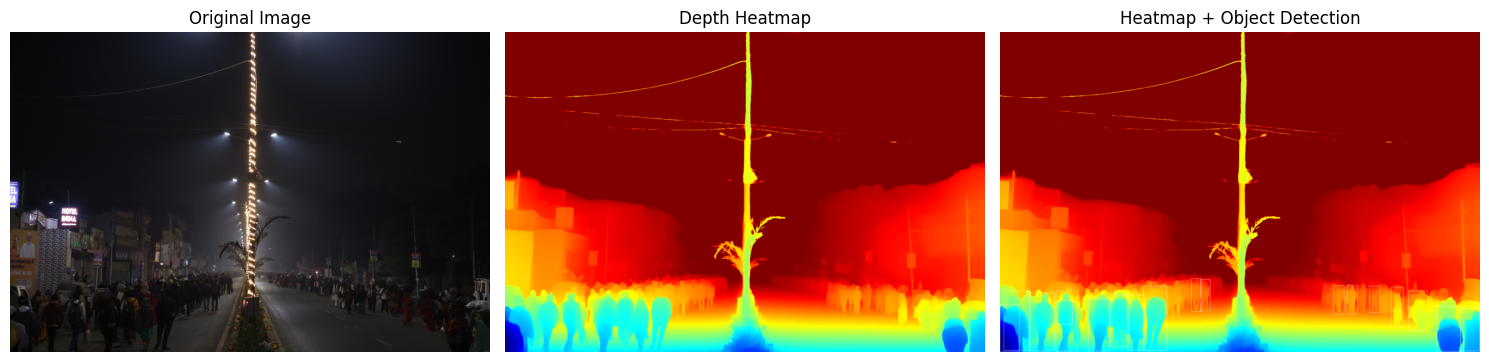

In [ ]:
import cv2

# Upload and process one image
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run depth estimation
original, heatmap = estimate_depth(image_path)

# Run object detection
detection_result = detect_objects(image_path)

# Draw bounding boxes on heatmap
def draw_detections(heatmap, detection_result):
    annotated_heatmap = heatmap.copy()

    for box in detection_result.boxes.xyxy:  # Get bounding boxes
        x1, y1, x2, y2 = map(int, box)  # Convert to int
        cv2.rectangle(annotated_heatmap, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White box

    return annotated_heatmap

# Overlay object detection on heatmap
annotated_heatmap = draw_detections(heatmap, detection_result)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap)
ax[1].set_title("Depth Heatmap")
ax[1].axis("off")

ax[2].imshow(annotated_heatmap)
ax[2].set_title("Heatmap + Object Detection")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Saving IMG_0260.JPG to IMG_0260 (1).JPG

image 1/1 /content/Distill-Any-Depth/IMG_0260 (1).JPG: 448x640 6 persons, 1 backpack, 20.4ms
Speed: 3.5ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


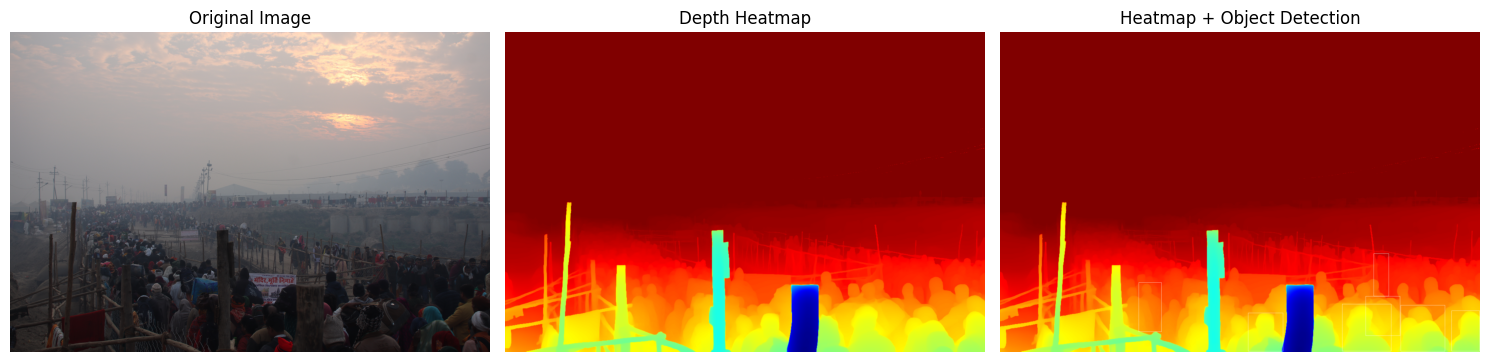

In [ ]:
import cv2

# Upload and process one image
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run depth estimation
original, heatmap = estimate_depth(image_path)

# Run object detection
detection_result = detect_objects(image_path)

# Draw bounding boxes on heatmap
def draw_detections(heatmap, detection_result):
    annotated_heatmap = heatmap.copy()

    for box in detection_result.boxes.xyxy:  # Get bounding boxes
        x1, y1, x2, y2 = map(int, box)  # Convert to int
        cv2.rectangle(annotated_heatmap, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White box

    return annotated_heatmap

# Overlay object detection on heatmap
annotated_heatmap = draw_detections(heatmap, detection_result)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap)
ax[1].set_title("Depth Heatmap")
ax[1].axis("off")

ax[2].imshow(annotated_heatmap)
ax[2].set_title("Heatmap + Object Detection")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Saving IMG_0283.JPG to IMG_0283 (1).JPG

image 1/1 /content/Distill-Any-Depth/IMG_0283 (1).JPG: 448x640 13 persons, 4 boats, 1 backpack, 6 umbrellas, 1 handbag, 20.6ms
Speed: 3.8ms preprocess, 20.6ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)


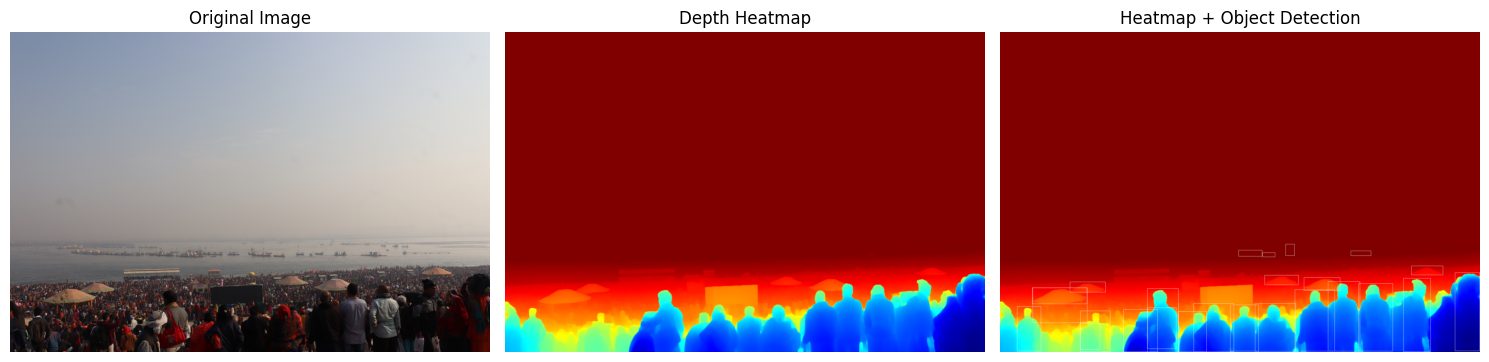

In [ ]:
import cv2

# Upload and process one image
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run depth estimation
original, heatmap = estimate_depth(image_path)

# Run object detection
detection_result = detect_objects(image_path)

# Draw bounding boxes on heatmap
def draw_detections(heatmap, detection_result):
    annotated_heatmap = heatmap.copy()

    for box in detection_result.boxes.xyxy:  # Get bounding boxes
        x1, y1, x2, y2 = map(int, box)  # Convert to int
        cv2.rectangle(annotated_heatmap, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White box

    return annotated_heatmap

# Overlay object detection on heatmap
annotated_heatmap = draw_detections(heatmap, detection_result)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap)
ax[1].set_title("Depth Heatmap")
ax[1].axis("off")

ax[2].imshow(annotated_heatmap)
ax[2].set_title("Heatmap + Object Detection")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Saving IMG_0433.JPG to IMG_0433.JPG

image 1/1 /content/Distill-Any-Depth/IMG_0433.JPG: 448x640 27 persons, 1 boat, 1 backpack, 1 umbrella, 19.9ms
Speed: 3.4ms preprocess, 19.9ms inference, 1.8ms postprocess per image at shape (1, 3, 448, 640)


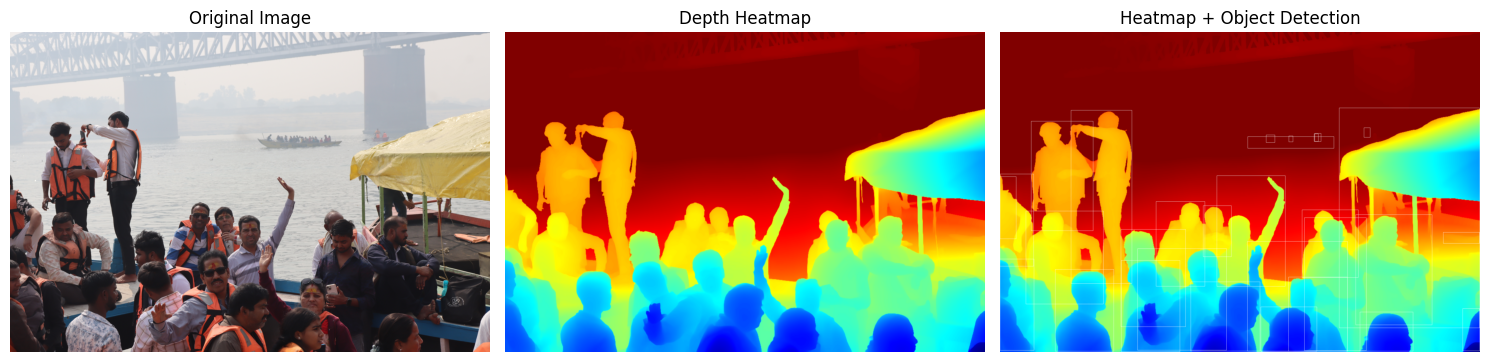

In [ ]:
import cv2

# Upload and process one image
from google.colab import files

uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Run depth estimation
original, heatmap = estimate_depth(image_path)

# Run object detection
detection_result = detect_objects(image_path)

# Draw bounding boxes on heatmap
def draw_detections(heatmap, detection_result):
    annotated_heatmap = heatmap.copy()

    for box in detection_result.boxes.xyxy:  # Get bounding boxes
        x1, y1, x2, y2 = map(int, box)  # Convert to int
        cv2.rectangle(annotated_heatmap, (x1, y1), (x2, y2), (255, 255, 255), 2)  # White box

    return annotated_heatmap

# Overlay object detection on heatmap
annotated_heatmap = draw_detections(heatmap, detection_result)

# Show results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(heatmap)
ax[1].set_title("Depth Heatmap")
ax[1].axis("off")

ax[2].imshow(annotated_heatmap)
ax[2].set_title("Heatmap + Object Detection")
ax[2].axis("off")

plt.tight_layout()
plt.show()